# KOH Posterior Analysis using Mici

This notebook implements the same model as the `mici-GRWM-matlabmodel.ipynb` notebook. This notebook differs by using JAX's automatic differentiation to implement gradient based MCMC methods using Mici.

In [1]:
from models import matlabmodel as KOHmodel
from data.dataloadermatlab import DataLoader
from kohgpjax.mappings import mapRto01, map01toR, mapRto0inf, map0inftoR
from MATLAB_mappings import ell2rho, beta2ell
from jax import jit, grad

import numpy as np
import matplotlib.pyplot as plt

import mici
import arviz

from truefuncs import zeta, eta

plot_style = {
    'mathtext.fontset': 'cm',
    'font.family': 'serif',
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
}

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


# The Data

In [2]:
dataloader = DataLoader('data/matlab/simple_field_medium.csv', 'data/matlab/simple_comp.csv')
data = dataloader.get_data() # loads normalised/standardised data
model = KOHmodel.MatlabModel(*data)

tmax = dataloader.t_max
tmin = dataloader.t_min

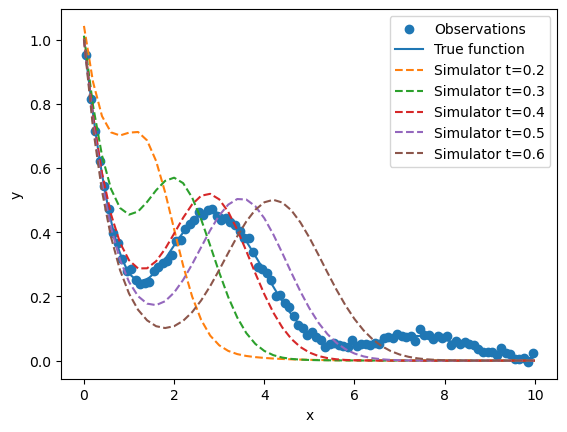

In [3]:
fig, ax = plt.subplots(1, 1)
ax.scatter(dataloader.xf, dataloader.yf, label='Observations')
ax.plot(dataloader.xf, zeta(dataloader.xf, 0.4), label='True function')
for t in [0.2, 0.3, 0.4, 0.5, 0.6]:
    rows = dataloader.tc==t
    ax.plot(dataloader.xc[rows], dataloader.yc[rows], '--', label=f'Simulator t={t}')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.show()

# MCMC Setup

In [4]:
init_states = np.array([[
    map01toR(0.4257), 
    map0inftoR(beta2ell(51.5551)), #these are the beta values!!!
    map0inftoR(beta2ell(3.5455)), 
    # map0inftoR(beta2ell(2)), 
    map0inftoR(0.25557), 
    map0inftoR(37.0552), 
    map0inftoR(10030.5142), 
    map0inftoR(79548.2126)
]])

Build the transform function to translate Mici's unbounded parameters into bounded GPJAX parameters.
This is passed to KOHGPJax.

In [5]:
param_transform_mici_to_gpjax = lambda x: [
    [ # theta (calibration) parameters
        mapRto01(x[0])
    ],
    [ # lengthscale parameters
        mapRto0inf(x[1]), 
        mapRto0inf(x[2]), 
    ],
    [ # lambda (variance) parameters
        mapRto0inf(x[3]), 
        mapRto0inf(x[4]), 
        mapRto0inf(x[5]), 
        mapRto0inf(x[6])
    ]
]

Build the function for evaluating the negative log posterior density.

This function is jitted and grad jitted using JAX. Finally the JAX functions are wrapped into a numpy function for clean interactions with Mici.

In [6]:
jitted_neg_log_posterior_density = jit(
    model.get_KOH_neg_log_pos_dens_func(
        param_transform_mici_to_gpjax
    )
)
grad_neg_log_posterior_density = jit(grad(
    model.get_KOH_neg_log_pos_dens_func(
        param_transform_mici_to_gpjax
    )
))

def neg_log_pos_dens(x):
    return np.asarray(jitted_neg_log_posterior_density(x))

def grad_neg_log_pos_dens(x):
    return np.asarray(grad_neg_log_posterior_density(x))

##### Mici #####
system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=neg_log_pos_dens,
    grad_neg_log_dens=grad_neg_log_pos_dens,
)
integrator = mici.integrators.LeapfrogIntegrator(system)

# Running MCMC algorithm

In [7]:
seed = 1234
n_chain = 1 # only 1 works on MacOS
n_warm_up_iter = 4000
n_main_iter = 10000
rng = np.random.default_rng(seed)

##### Mici sampler and adapters #####
sampler = mici.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=1)
adapters = [
    mici.adapters.DualAveragingStepSizeAdapter(0.8),
    mici.adapters.OnlineCovarianceMetricAdapter()
]

def trace_func(state):
    return {
        'theta': state.pos[0], 
        'ell_eta_1': state.pos[1], 
        'ell_eta_2': state.pos[2],
        'lambda_eta': state.pos[3],
        'lambda_delta': state.pos[4],
        'lambda_epsilon': state.pos[5],
        'lambda_epsilon_eta': state.pos[6],
        'hamiltonian': system.h(state)
    }

final_states, traces, stats = sampler.sample_chains(
    n_warm_up_iter, 
    n_main_iter, 
    init_states, 
    adapters=adapters, 
    n_process=n_chain, # only 1 works on MacOS
    trace_funcs=[trace_func]
)

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


Sampling stage: Initial fast adaptive [00:06] > Slow adaptive (1/7) [00:01] > Slow adaptive (2/7) [00:02] > Slow adaptive (3/7) [00:04] > Slow adaptive (4/7) [00:08] > Slow adaptive (5/7) [00:17] > Slow adaptive (6/7) [00:39] > Slow adaptive (7/7) [01:41] > Final fast adaptive [00:02] > Main non-adaptive [04:25]

Chain 1/1: 100%|██████████|10000/10000 [04:25<00:00, 37.68it/s, accept_stat=0.912]

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/mici/systems.py:189: RuntimeWarning: invalid value encountered in add
  return self.h1(state) + self.h2(state)


# Analyse MCMC output

In [8]:
arviz.summary(traces)

Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.294,0.069,0.170,0.426,0.002,0.002,864.0,1120.0,NaN
ell_eta_1,-2.193,0.023,-2.235,-2.148,0.001,0.000,1134.0,2159.0,NaN
ell_eta_2,-1.413,0.047,-1.500,-1.324,0.001,0.001,1157.0,1577.0,NaN
lambda_eta,-1.877,0.210,-2.290,-1.506,0.007,0.005,1026.0,2086.0,NaN
lambda_delta,4.972,0.143,4.707,5.242,0.005,0.003,945.0,1719.0,NaN
lambda_epsilon,9.108,0.328,8.495,9.711,0.010,0.007,1146.0,2119.0,NaN
lambda_epsilon_eta,11.236,0.111,11.030,11.442,0.003,0.002,1059.0,2106.0,NaN
hamiltonian,-860.801,2.675,-865.413,-855.783,0.054,0.038,2467.0,4521.0,NaN


In [9]:
for var, trace in traces.items():
    print(var, ": ", np.mean(trace[0]), '±', np.std(trace[0]))

theta :  0.2938192430773671 ± 0.06857257855603084
ell_eta_1 :  -2.193151294948605 ± 0.02330617929874665
ell_eta_2 :  -1.4128652831062685 ± 0.04671024644954157
lambda_eta :  -1.8766356191355804 ± 0.2095916219823069
lambda_delta :  4.972435525855638 ± 0.14274382152398682
lambda_epsilon :  9.108063615865527 ± 0.3275294709450959
lambda_epsilon_eta :  11.236486666881975 ± 0.1109689983758623
hamiltonian :  -860.8010235017048 ± 2.67455261222235


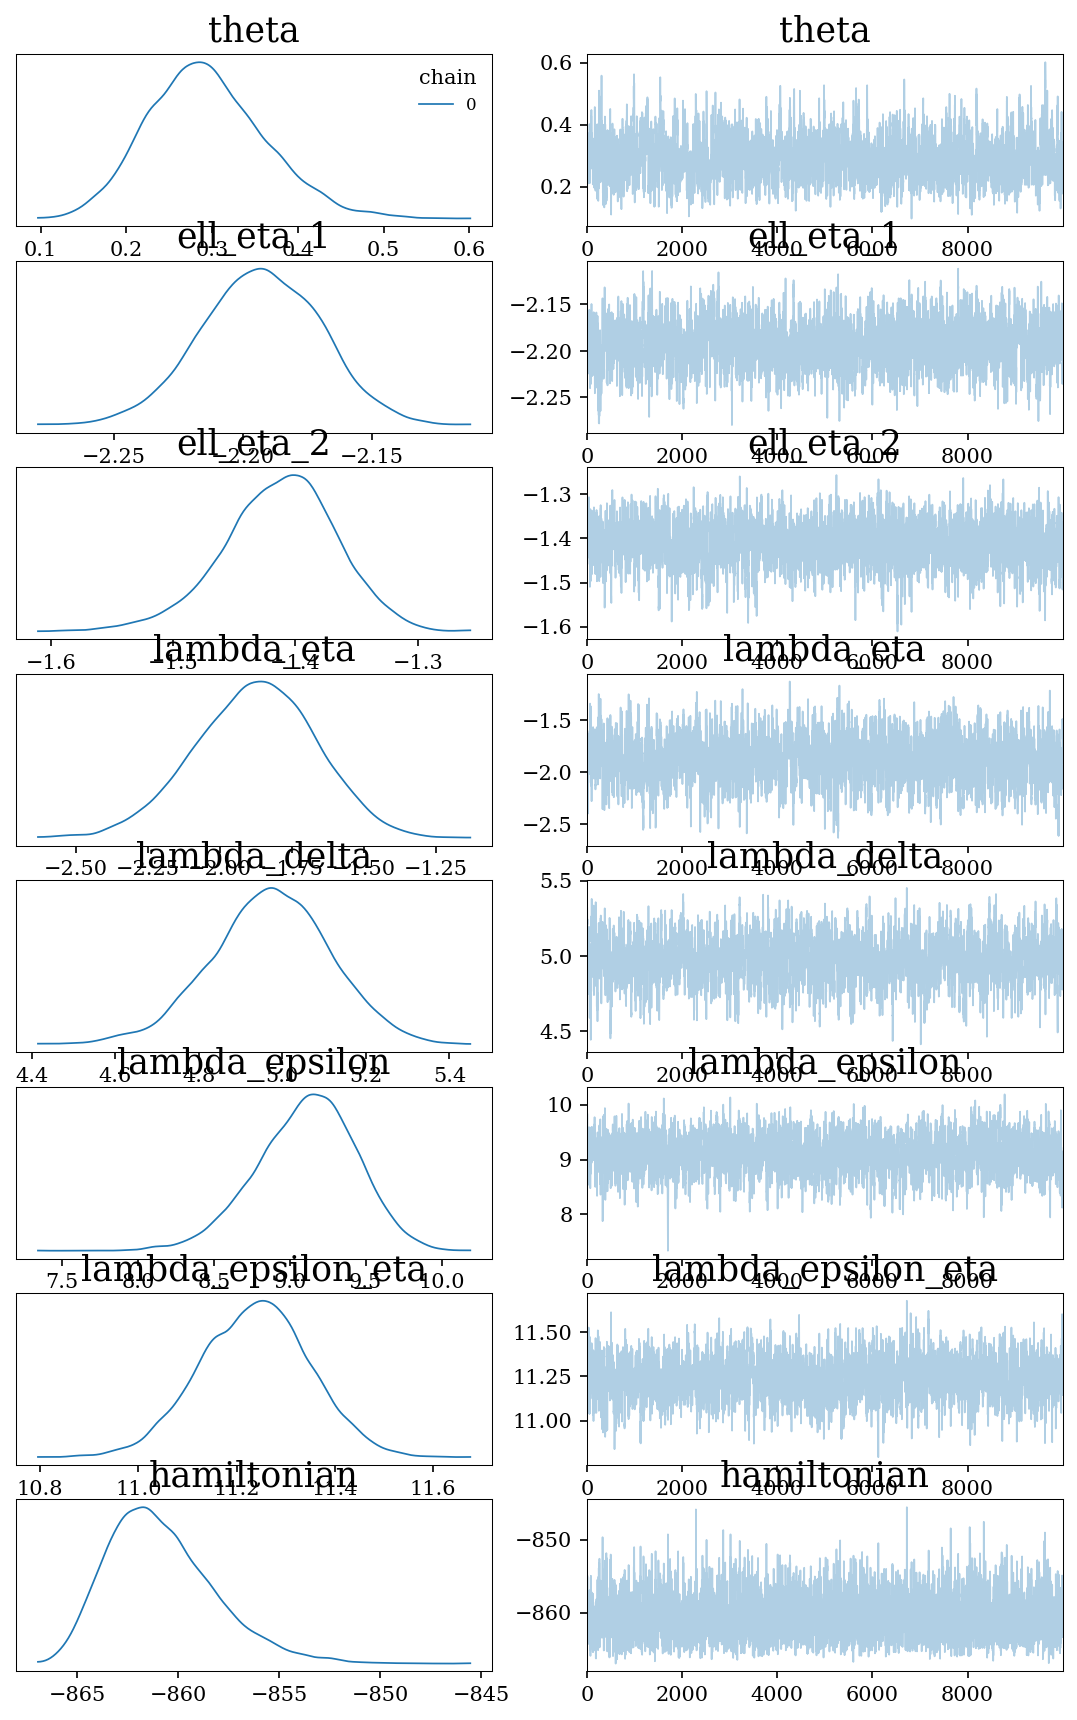

In [10]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces,
        # var_names=["σ", "ϵ", "γ", "β", "x_0"],
        figsize=(9, 2 * (7)),
        legend=True,
        compact=False,
    )


# Transform the Chains

In [11]:
traces_transformed = {}
for var, trace in traces.items():
    if var == 'theta':
        traces_transformed[var] = mapRto01(trace[0])*(tmax-tmin) + tmin
    elif var.startswith('ell'):
        traces_transformed[var] = mapRto0inf(trace[0])
    elif var.startswith('lambda'):
        traces_transformed[var] = mapRto0inf(trace[0])

params_transformed = {}
for var, trace in traces_transformed.items():
    params_transformed[var] = np.mean(trace)
    print(var, ": ", np.mean(trace), '±', np.std(trace))

theta :  0.37086211324191337 ± 0.006690537153667612
ell_eta_1 :  0.11159490645135539 ± 0.0025988210241094127
ell_eta_2 :  0.24370920579016003 ± 0.011309738088539639
lambda_eta :  0.15647192686070108 ± 0.032673111012044134
lambda_delta :  145.8460383515458 ± 20.707193603095753
lambda_epsilon :  9508.323668734372 ± 3039.8104649450274
lambda_epsilon_eta :  76315.40721620746 ± 8466.521279205668


In [12]:
arviz.summary(traces_transformed)

Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.371,0.007,0.358,0.383,0.000,0.000,864.0,1120.0,NaN
ell_eta_1,0.112,0.003,0.107,0.117,0.000,0.000,1134.0,2159.0,NaN
ell_eta_2,0.244,0.011,0.222,0.265,0.000,0.000,1157.0,1577.0,NaN
lambda_eta,0.156,0.033,0.099,0.219,0.001,0.001,1026.0,2086.0,NaN
lambda_delta,145.846,20.708,110.121,188.286,0.672,0.475,945.0,1719.0,NaN
lambda_epsilon,9508.324,3039.962,4277.352,15310.992,87.597,61.955,1146.0,2119.0,NaN
lambda_epsilon_eta,76315.407,8466.945,61320.140,92684.187,258.330,182.717,1059.0,2106.0,NaN


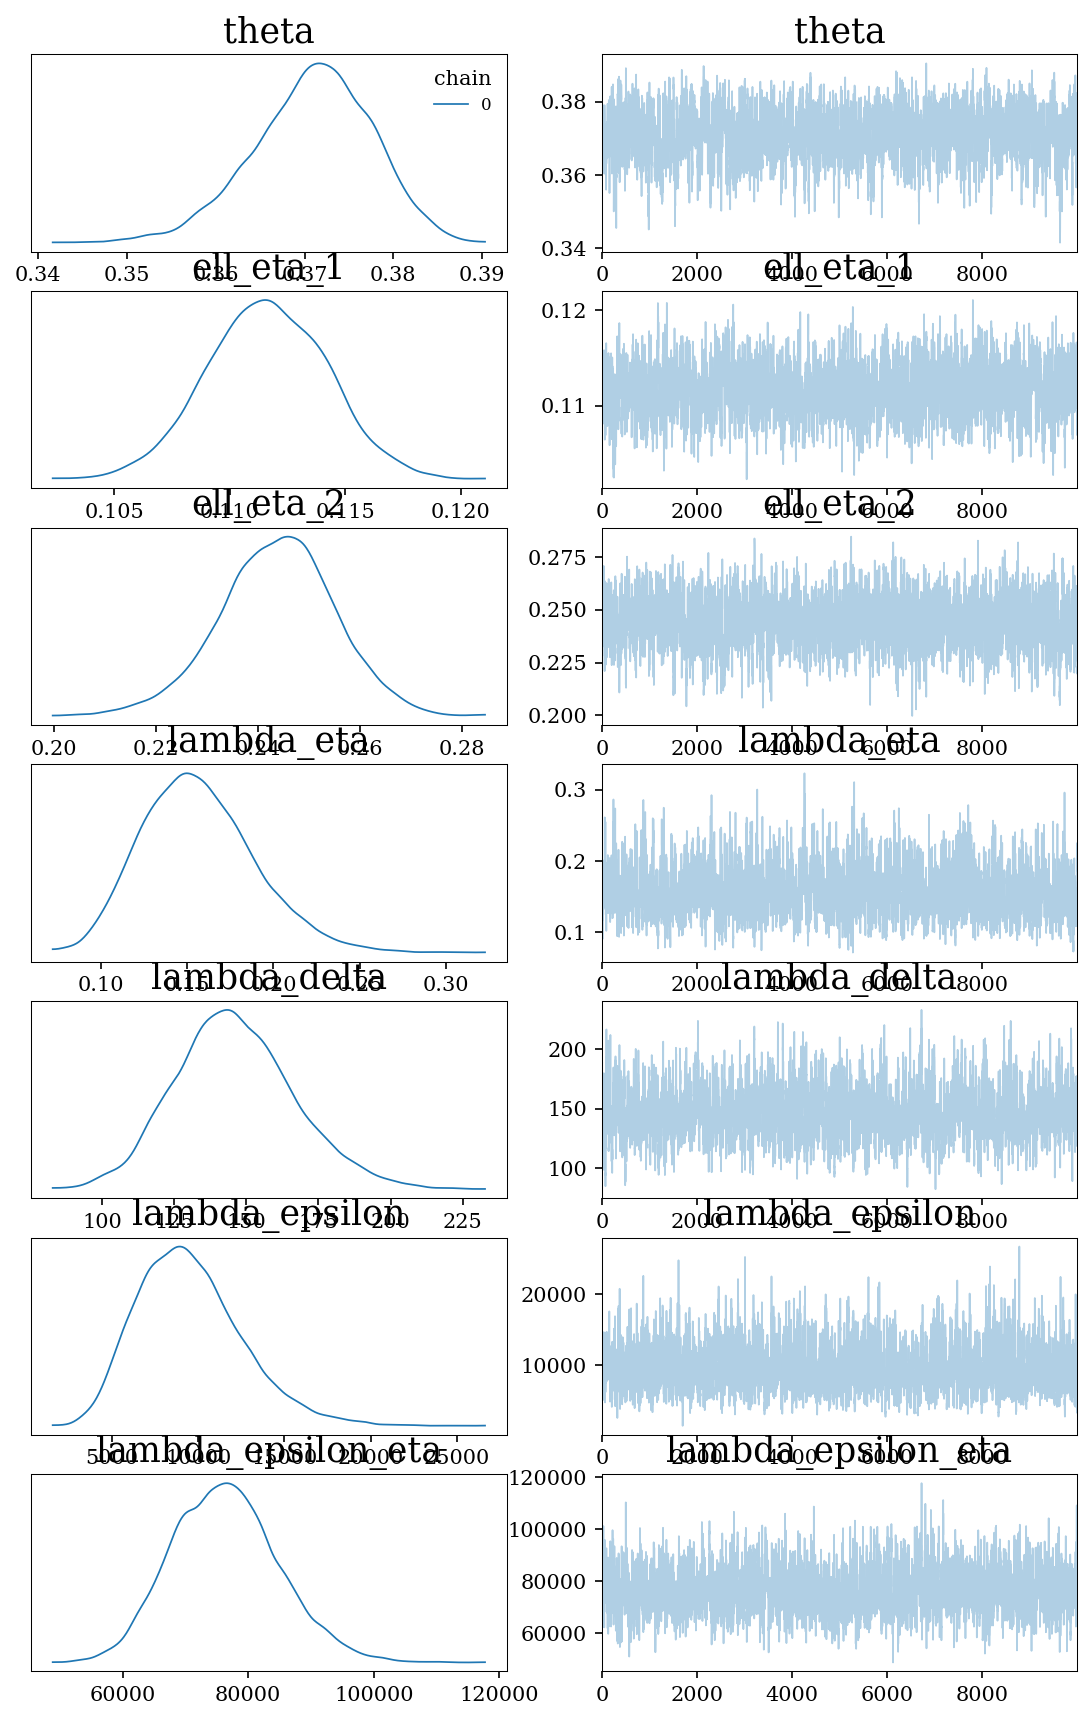

In [13]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces_transformed,
        figsize=(9, 2 * (7)),
        legend=True,
        compact=False,
    )
plt.show()

# Analyse posterior fit

## Prediction data

In [14]:
xpred = np.linspace(0, 10, 1000) # for predictions

xp_normalised = (xpred-np.min(xpred))/(np.max(xpred)-np.min(xpred))
theta_transformed = mapRto01(np.mean(traces['theta'])) # transform theta back to [0, 1]

x_test = np.vstack((xp_normalised, theta_transformed*np.ones_like(xp_normalised))).T
dataset = model.dataset(theta_transformed)

## Posterior GPs

In [15]:
GP_posterior = model.GP_posterior(
    param_transform_mici_to_gpjax(
        [np.mean(x) for x in traces.values()]
    )
)

eta_pred = GP_posterior.predict_eta(
    x_test,
    dataset
)
zeta_pred = GP_posterior.predict_obs(
    x_test,
    dataset
)
obs_pred = GP_posterior.predict_obs(
    x_test,
    dataset
)


eta_pred_m = dataloader.inverse_transform_y(eta_pred.mean()) # transform back to original scale
eta_pred_v = dataloader.inverse_transform_y_cov(eta_pred.variance()) # transform back to original scale
eta_pred_sd = np.sqrt(eta_pred_v)


zeta_pred_m = dataloader.inverse_transform_y(zeta_pred.mean()) # transform back to original scale
zeta_pred_v = dataloader.inverse_transform_y_cov(zeta_pred.variance()) # transform back to original scale
zeta_pred_sd = np.sqrt(zeta_pred_v)

obs_pred_m = dataloader.inverse_transform_y(obs_pred.mean()) # transform back to original scale
obs_pred_v = dataloader.inverse_transform_y_cov(obs_pred.variance()) # transform back to original scale
obs_pred_sd = np.sqrt(obs_pred_v)

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


## Plot GP modelling simulator

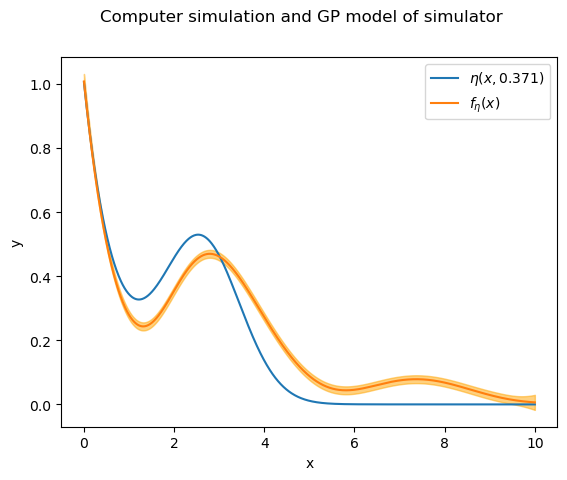

In [16]:
theta = params_transformed['theta']

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(xpred, eta(xpred, theta), label=fr'$\eta(x, {theta:.3f})$')
ax.plot(xpred, eta_pred_m, label=r'$f_\eta(x)$')
ax.fill_between(
    xpred, 
    eta_pred_m-1.96*eta_pred_sd, 
    eta_pred_m+1.96*eta_pred_sd, 
    alpha=0.5, 
    color='orange'
)
# ax.scatter(obs_x, obs_y, label="observations")

ax.legend()
fig.suptitle("Computer simulation and GP model of simulator")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

## Plot GP modelling true process

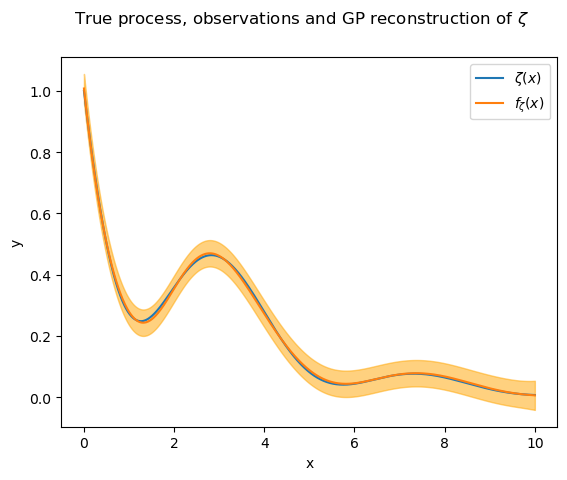

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(xpred, zeta(xpred), label=r'$\zeta(x)$')
ax.plot(xpred, zeta_pred_m, label=r'$f_\zeta(x)$')
ax.fill_between(
    xpred, 
    zeta_pred_m-1.96*zeta_pred_sd, 
    zeta_pred_m+1.96*zeta_pred_sd, 
    alpha=0.5, 
    color='orange'
)
# ax.scatter(obs_x, obs_y, label="observations")

ax.legend()
fig.suptitle("True process, observations and GP reconstruction of $\zeta$")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

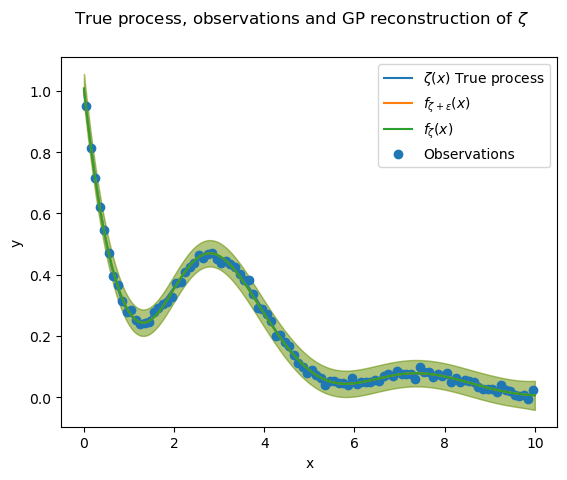

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(xpred, zeta(xpred), label=r'$\zeta(x)$ True process')
ax.plot(xpred, obs_pred_m, label=r'$f_{\zeta+\epsilon}(x)$')
ax.fill_between(
    xpred, 
    obs_pred_m-1.96*obs_pred_sd, 
    obs_pred_m+1.96*obs_pred_sd, 
    alpha=0.3, 
    color='orange'
)
ax.plot(xpred, zeta_pred_m, label=r'$f_{\zeta}(x)$')
ax.fill_between(
    xpred, 
    zeta_pred_m-1.96*zeta_pred_sd, 
    zeta_pred_m+1.96*zeta_pred_sd, 
    alpha=0.3, 
    color='green'
)
ax.scatter(dataloader.xf, dataloader.yf, label="Observations")

ax.legend()
fig.suptitle("True process, observations and GP reconstruction of $\zeta$")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

## Dicrepancy Testing

In [19]:
delta_gp_m = zeta_pred_m - eta_pred_m
delta_gp_v = zeta_pred_v + eta_pred_v
delta_gp_sd = np.sqrt(delta_gp_v)

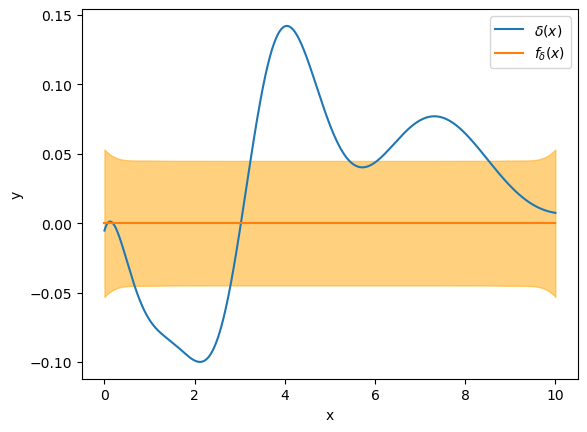

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(xpred, zeta(xpred) - eta(xpred, theta), label=r'$\delta(x)$')
ax.plot(xpred, delta_gp_m, label=r'$f_\delta(x)$')
ax.fill_between(
    xpred, 
    delta_gp_m-1.96*delta_gp_sd, 
    delta_gp_m+1.96*delta_gp_sd, 
    alpha=0.5, 
    color='orange'
)
# ax.scatter(obs_x, obs_y, label="observations")

ax.legend()
# fig.suptitle("True process, observations and GP reconstruction of $\zeta$")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()